In [1]:
from __future__ import division
import os
from collections import defaultdict
import itertools
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pyprind

import comptools as comp

from save_pyunfold_format import save_pyunfold_root_file
from run_unfolding import unfold
    
# color_dict allows for a consistent color-coding for each composition
color_dict = comp.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# config = 'IC79.2010'
config = 'IC86.2012'
num_groups = 4
comp_list = comp.get_comp_list(num_groups=num_groups)

In [3]:
energybins = comp.get_energybins(config)

In [4]:
feature_list, feature_labels = comp.get_training_features()
pipeline_str = 'BDT_comp_{}_{}-groups'.format(config, num_groups)

In [5]:
unfolding_dir  = os.path.join(comp.paths.comp_data_dir, config,
                              'unfolding')
figures_dir  = os.path.join(comp.paths.figures_dir, 'unfolding', config,
                            'datachallenge')

In [6]:
df_data = comp.load_data(config=config,
                         log_energy_min=energybins.log_energy_min,
                         log_energy_max=energybins.log_energy_max,
                         columns=feature_list,
                         n_jobs=10, verbose=True)

[########################################] | 100% Completed |  7min 54.4s


/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


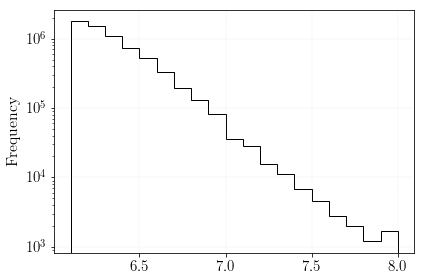

In [7]:
fig, ax = plt.subplots()
df_data.reco_log_energy.plot(kind='hist', histtype='step', bins=energybins.log_energy_bins,
                             color=color_dict['data'], logy=True, ax=ax)
ax.grid()
plt.show()

## Load simulation & train BDT

In [6]:
df_sim_train, df_sim_test = comp.load_sim(config=config,
                                          log_energy_min=energybins.log_energy_min,
                                          log_energy_max=energybins.log_energy_max,
                                          test_size=0.5,
                                          verbose=True)

[########################################] | 100% Completed |  1.0s


In [7]:
pipeline = comp.get_pipeline(pipeline_str)

# Fit composition classifier
print('Fitting composition classifier...')
pipeline = pipeline.fit(df_sim_train[feature_list],
                        df_sim_train['comp_target_{}'.format(num_groups)])

Fitting composition classifier...


/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


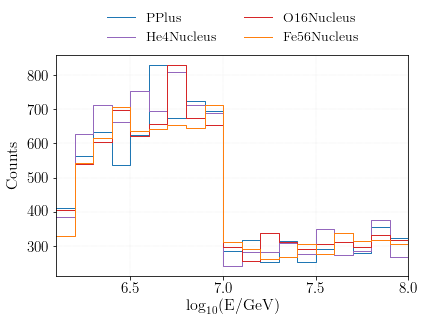

In [8]:
fig, ax = plt.subplots()
for composition in comp_list:
    comp_mask = df_sim_test['comp_group_{}'.format(num_groups)] == composition
    counts = np.histogram(df_sim_test.loc[comp_mask, 'MC_log_energy'], bins=energybins.log_energy_bins)[0]
    comp.plot_steps(energybins.log_energy_bins, counts, label=composition,
                    color=color_dict[composition], ax=ax)

ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('Counts')
ax.grid()

leg = plt.legend(
                 loc='upper center', frameon=False,
                 bbox_to_anchor=(0.5,  # horizontal
                                 1.25),# vertical 
                 ncol=len(comp_list)//2, fancybox=False)
nevents_outfile = os.path.join(figures_dir, 'num_testing_sim_events.png'.format(config))
comp.check_output_dir(nevents_outfile)
plt.savefig(nevents_outfile)
plt.show()

Plot true flux

In [9]:
# Solid angle
theta_max = 40 if config == 'IC79.2010' else 65
# solid_angle = 2*np.pi*(np.cos(df_sim_train['lap_zenith'].min())-np.cos(df_sim_train['lap_zenith'].max()))
solid_angle = np.pi*np.sin(np.deg2rad(theta_max))**2
solid_angle

2.5804847429997841

In [10]:
livetime, livetime_err = comp.get_detector_livetime(config=config)
livetime, livetime_err

(28442248.921, 2699.1328177300002)

In [11]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_areas = np.pi * thrown_radii**2
thrown_area = thrown_areas.max()
print('thrown_area = {}'.format(thrown_area))

thrown_area = 9079202.76887


In [12]:
# Load fitted effective area
print('Loading detection efficiencies...')
eff_path = os.path.join(
                comp.paths.comp_data_dir, config, 'efficiencies',
                'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
df_eff = pd.read_hdf(eff_path)

Loading detection efficiencies...


In [13]:
df_eff.head()

,eff_median_PPlus,eff_err_low_PPlus,eff_err_high_PPlus,eff_median_He4Nucleus,eff_err_low_He4Nucleus,eff_err_high_He4Nucleus,eff_median_O16Nucleus,eff_err_low_O16Nucleus,eff_err_high_O16Nucleus,eff_median_Fe56Nucleus,eff_err_low_Fe56Nucleus,eff_err_high_Fe56Nucleus,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.006811,0.000106,0.000107,0.007278,0.000120,0.000113,0.006527,0.000120,0.000106,0.006132,0.000123,0.000116,0.006691,0.000056,0.000059
1,0.007645,0.000097,0.000102,0.008170,0.000093,0.000089,0.007697,0.000102,0.000090,0.007539,0.000102,0.000101,0.007762,0.000047,0.000049
2,0.008183,0.000079,0.000090,0.008620,0.000071,0.000072,0.008328,0.000075,0.000068,0.008263,0.000073,0.000069,0.008365,0.000037,0.000036
3,0.008509,0.000068,0.000073,0.008828,0.000067,0.000068,0.008626,0.000068,0.000065,0.008573,0.000066,0.000063,0.008668,0.000033,0.000032
4,0.008697,0.000067,0.000069,0.008921,0.000072,0.000070,0.008759,0.000071,0.000067,0.008697,0.000067,0.000069,0.008812,0.000034,0.000034


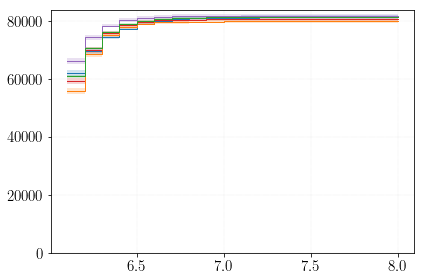

In [14]:
eff_area, eff_area_err = {}, {}
fig, ax = plt.subplots()
for composition in comp_list+['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)]*thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)]*thrown_area
    comp.plot_steps(energybins.log_energy_bins, eff_area[composition], eff_area_err[composition], 
                    color=color_dict[composition], label=composition, ax=ax)
ax.set_ylim(0)
ax.grid()
plt.show()

Generate fake counts distribution for each composition

(In the future, this will be specified by Josh/Zach)

In [15]:
def broken_power_law_flux(energy, gamma_before=-2.7, gamma_after=-3.1, energy_break=3e6):
    """Broken power law flux

    This is a "realistic" flux (simple broken power law with a knee @ 3PeV)
    to weight simulation to. More information can be found on the
    IT73-IC79 data-MC comparison wiki page
    https://wiki.icecube.wisc.edu/index.php/IT73-IC79_Data-MC_Comparison
    
    Parameters
    ----------
    energy : array_like
        Energy values (in GeV) to calculate the flux for. 
    gamma_before : float, optional
        Spectral index before break point (default is -2.7). 
    gamma_after : float, optional
        Spectral index after break point (default is -3.1). 
    energy_break : float, optional
        Energy (in GeV) at which the spectral index break occurs
        (default is 3e6, or 3 PeV).
        
    Returns
    -------
    flux : array_like 
        Broken power law evaluated at energy points. 
    """
    phi_0 = 3.6e-6
    # phi_0 = 3.1e-6
    # phi_0 = 2.95e-6
    eps = 100
    if isinstance(energy, (int, float)):
        energy = [energy]
    energy = np.asarray(energy) * 1e-6
    energy_break = energy_break * 1e-6
    
    flux = (1e-6) * phi_0 * energy**gamma_before *(1+(energy/energy_break)**eps)**((gamma_after-gamma_before)/eps)

    return flux

In [16]:
random_state = 2
np.random.seed(random_state)

In [85]:
case = 'broken_power_law_3'

In [88]:
counts_true = pd.DataFrame(index=energybins.log_energy_midpoints,
                           columns=comp_list)

flux_to_counts_scaling = {}
for composition in comp_list:
    flux_to_counts_scaling[composition] = eff_area[composition].values * livetime * solid_angle * energybins.energy_bin_widths

if case == 'constant':
    for composition in comp_list:
        counts_true[composition] = np.array([1000]*len(energybins.log_energy_midpoints))

elif case == 'constants':
    for composition, value in zip(comp_list, [1000, 800, 700, 600]):
        counts_true[composition] = np.array([value]*len(energybins.log_energy_midpoints))

elif case == 'broken_power_law_0':
    for composition in comp_list:
        scale = 1.0 / len(comp_list)
        comp_flux = comp.broken_power_law_flux(energybins.energy_midpoints,
                                               energy_break=3e12)
        comp_flux *= scale
        counts_true[composition] = flux_to_counts_scaling[composition] * comp_flux

elif case == 'broken_power_law_1':
    for composition in comp_list:
        scale = 1.0 / len(comp_list)
        comp_flux = scale * comp.broken_power_law_flux(energybins.energy_midpoints, energy_break=10**7.0)
        counts_true[composition] = flux_to_counts_scaling[composition] * comp_flux

elif case == 'broken_power_law_2':
    for composition in comp_list:
        high_energy_mask = energybins.log_energy_midpoints >= 7.0
        comp_flux = comp.broken_power_law_flux(energybins.energy_midpoints, energy_break=12e6)
        counts_true[composition] = flux_to_counts_scaling[composition] * comp_flux
        if composition in ['PPlus', 'He4Nucleus']:
            counts_true.loc[high_energy_mask, composition] *= 0.25
        else:
            counts_true.loc[~high_energy_mask, composition] *= 0.25

elif case == 'broken_power_law_3':
    scales = [0.25, 0.1, 0.25, 0.4]
    assert sum(scales) == 1
    for composition, scale in zip(comp_list, scales):
        high_energy_mask = energybins.log_energy_midpoints >= 6.5
        comp_flux = scale * comp.broken_power_law_flux(energybins.energy_midpoints)
        counts_true[composition] = flux_to_counts_scaling[composition] * comp_flux

elif case == 'H4a':
    model_flux = comp.model_flux(model='H4a',
                                 energy=energybins.energy_midpoints,
                                 num_groups=num_groups)
    for composition in comp_list:
        counts_true[composition] = model_flux['flux_{}'.format(composition)].values * flux_to_counts_scaling[composition]

else:
    raise ValueError('Invalid case, {}, entered'.format(case))


# Calculate total counts
counts_true['total'] = counts_true.sum(axis=1)

counts_true

,PPlus,He4Nucleus,O16Nucleus,Fe56Nucleus,total
6.15,524044.524018,223968.530017,502160.796436,754798.635862,2.004972e+06
6.25,397637.534997,169992.853711,400376.213004,627406.015034,1.595413e+06
6.35,287754.553435,121255.332912,292855.998536,464926.934800,1.166793e+06
6.45,202296.444063,83957.530886,205094.252168,326104.652542,8.174529e+05
6.55,130721.683350,53635.405626,131657.895000,209162.666846,5.251777e+05
6.65,81568.721795,33214.544532,81707.808880,129698.826679,3.261899e+05
6.75,50636.182314,20518.482382,50513.352982,80149.510828,2.018175e+05
6.85,31332.160688,12662.134981,31184.587281,49459.164349,1.246380e+05
6.95,19358.483398,7810.566542,19237.981330,30506.417277,7.691345e+04
7.05,11949.537107,4816.719709,11864.992786,18811.953073,4.744320e+04


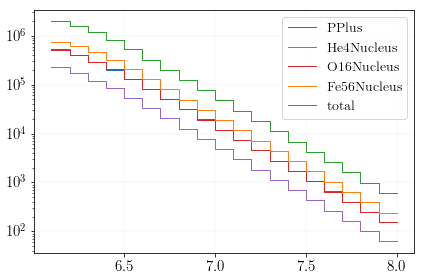

In [89]:
fig, ax = plt.subplots()
for composition in counts_true:
    comp.plot_steps(energybins.log_energy_bins, counts_true[composition],
                    color=color_dict[composition], label=composition,
                    ax=ax)
ax.set_yscale("log", nonposy='clip')
ax.grid()
ax.legend()
plt.show()

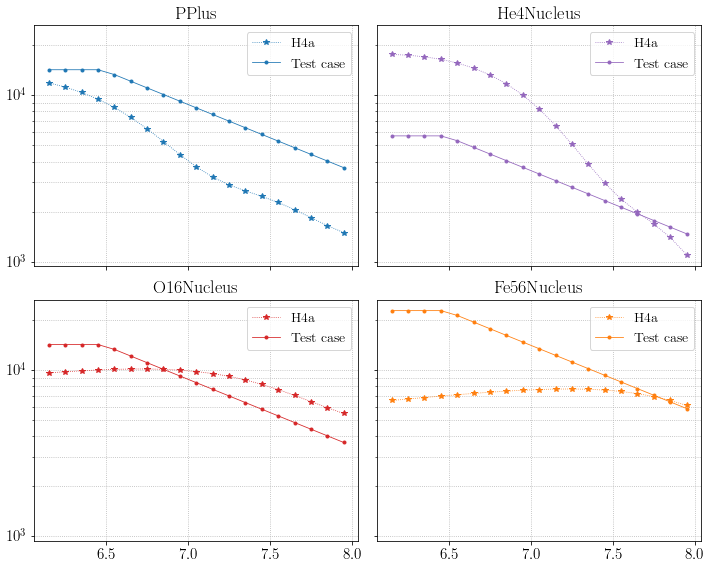

In [90]:
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
for composition, ax in zip(comp_list, axarr.flat):
    model_flux = comp.model_flux(model='H4a',
                                 energy=energybins.energy_midpoints,
                                 num_groups=num_groups)
    ax.plot(energybins.log_energy_midpoints,
            energybins.energy_midpoints**2.7*model_flux['flux_{}'.format(composition)].values,
            color=color_dict[composition], ls=':', marker='*',
            label='H4a')
    
    comp_flux = counts_true[composition] / flux_to_counts_scaling[composition]
    ax.plot(energybins.log_energy_midpoints,
            energybins.energy_midpoints**2.7*comp_flux,
            color=color_dict[composition],
            label='Test case',
            marker='.')
    ax.set_yscale("log", nonposy='clip')
    ax.set_title(composition)
    ax.grid(lw=0.8, which='both')
    ax.legend()
plt.show()

Calculate (testing set) simulation event weights

In [91]:
counts_sim = pd.DataFrame(index=energybins.log_energy_midpoints,
                          columns=comp_list)
for composition in comp_list:
    comp_mask = df_sim_test['comp_group_{}'.format(num_groups)] == composition
    comp_counts, _ = np.histogram(df_sim_test.loc[comp_mask, 'reco_log_energy'],
                                  bins=energybins.log_energy_bins)
    counts_sim[composition] = comp_counts

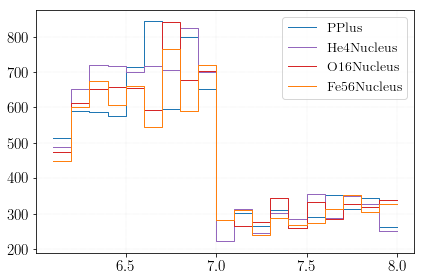

In [92]:
fig, ax = plt.subplots()
for composition in counts_sim:
    comp.plot_steps(energybins.log_energy_bins, counts_sim[composition],
                    color=color_dict[composition], label=composition)
ax.grid()
ax.legend()
plt.show()

## Run analysis pipeline on simulation

In [93]:
counts_observed = pd.DataFrame(0, index=energybins.log_energy_midpoints, columns=comp_list)
weights = pd.DataFrame(0, index=energybins.log_energy_midpoints, columns=comp_list)
for idx_log_energy, composition in itertools.product(range(len(energybins.log_energy_midpoints)),
                                                     comp_list):
    
    log_energy = energybins.log_energy_midpoints[idx_log_energy]
    
    # Construct composition mask
    comp_mask = df_sim_test['comp_group_{}'.format(num_groups)] == composition
    # Construct mask for energy bin
    energy_bins = np.digitize(df_sim_test['MC_log_energy'], bins=energybins.log_energy_bins) - 1
    energy_mask = energy_bins == idx_log_energy
    # Filter out events that don't pass composition + energy  mask
    df_sim_bin = df_sim_test.loc[comp_mask & energy_mask, :]
    
    # Reweight simulation events to get desired number of events
    weight = counts_true.loc[log_energy, composition] / df_sim_bin.shape[0]
    weights.loc[log_energy, composition] = weight
    
    # Get predicted composition 
    pred_target = pipeline.predict(df_sim_bin[feature_list])
    pred_comp = np.array(comp.decode_composition_groups(pred_target, num_groups=num_groups))
    assert len(pred_comp) == df_sim_bin.shape[0]
    for p_comp in np.unique(pred_comp):
        pred_comp_mask = pred_comp == p_comp
        comp_counts, _ = np.histogram(df_sim_bin.loc[pred_comp_mask, 'reco_log_energy'],
                                      bins=energybins.log_energy_bins)
        comp_counts = weight * comp_counts
        counts_observed[p_comp] += comp_counts

counts_observed

,PPlus,He4Nucleus,O16Nucleus,Fe56Nucleus
6.15,448470.697288,558708.028255,61553.669808,457597.477438
6.25,427392.360601,506010.333059,101575.191688,812860.867915
6.35,252150.662515,386208.748319,92743.879145,580312.258955
6.45,142369.251000,276002.149682,80052.314976,313334.978728
6.55,133460.857811,133049.535105,95735.160529,213504.458641
6.65,83376.010735,75875.898698,58160.413714,106996.788235
6.75,34462.117200,31866.906484,58290.156902,99715.117607
6.85,35283.446909,36356.733839,23134.933716,39156.472249
6.95,16521.814168,18516.644737,11872.678809,42945.073518
7.05,9254.816895,3030.297653,9593.263916,17140.732063


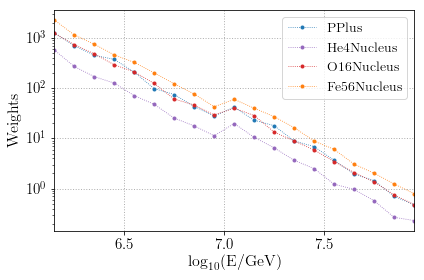

In [94]:
fig, ax = plt.subplots()
for composition in comp_list:
    weights[composition].plot(ls=':', label=composition,
                              color=color_dict[composition], ax=ax)
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_ylabel('Weights')
ax.set_yscale("log", nonposy='clip')
ax.grid(lw=1)
ax.legend()
weights_outfile = os.path.join(figures_dir, 
                               'weights.png'.format(num_groups))
comp.check_output_dir(weights_outfile)
plt.savefig(weights_outfile)
plt.show()

Format observed counts and detection efficiencies for use with PyUnfold

In [95]:
counts_pyunfold = []
for idx, row in counts_observed.iterrows():
    for composition in comp_list:
        counts_pyunfold.append(row[composition])
        
efficiencies = []
efficiencies_err = []     
for idx, row in df_eff.iterrows():
    for composition in comp_list:
        efficiencies.append(row['eff_median_{}'.format(composition)])
        efficiencies_err.append(row['eff_err_low_{}'.format(composition)])

In [96]:
formatted_df = pd.DataFrame()
formatted_df['counts'] = counts_pyunfold
formatted_df['efficiencies'] = efficiencies
formatted_df['efficiencies_err'] = efficiencies_err

In [97]:
formatted_df.head()

,counts,efficiencies,efficiencies_err
0,448470.697288,0.006811,0.000106
1,558708.028255,0.007278,0.000120
2,61553.669808,0.006527,0.000120
3,457597.477438,0.006132,0.000123
4,427392.360601,0.007645,0.000097


In [98]:
formatted_file = os.path.join(os.getcwd(),'test.hdf')
formatted_df.to_hdf(formatted_file, 'dataframe', mode='w')

In [99]:
root_file = os.path.join(os.getcwd(),'test.root')
save_pyunfold_root_file(config=config, num_groups=num_groups,
                        outfile=root_file, formatted_df_file=formatted_file)

Saving output file /home/jbourbeau/cr-composition/unfolding/test.root


In [100]:
df_unfolding_iter = unfold(config_name=os.path.join(config, 'config.cfg'),
                           priors='Jeffreys',
                           input_file=root_file,
                           ts_stopping=0.01)

In [101]:
df_unfolding_iter

,sys_err,stat_err,n_c
0,"[30935201.7749, 11344662.6106, 9235548.08932, ...","[122184.008615, 46610.4280331, 37728.3658056, ...","[226633519.476, 91231840.8719, 67295004.0953, ..."
1,"[34461344.924, 14225219.9294, 13754581.0252, 1...","[118640.243957, 50345.6997184, 53530.3499832, ...","[176191611.269, 81761596.2179, 71227463.8037, ..."
2,"[35226502.7542, 16255371.9133, 17448098.7779, ...","[129629.034574, 56711.1813067, 66470.4197135, ...","[147261343.808, 76136300.8899, 75621157.8449, ..."
3,"[34807668.5331, 17709227.8952, 20480735.676, 2...","[135797.488551, 62398.5226621, 77357.6900892, ...","[128575400.55, 72211935.1651, 79487075.4852, 6..."
4,"[33974539.1907, 18768212.2251, 22996578.9484, ...","[141354.651993, 68013.3915995, 86513.3238882, ...","[115689996.49, 69257499.95, 82641656.8536, 717..."
5,"[33099185.233, 19566405.2562, 25111389.131, 25...","[146304.979461, 73512.1696956, 94189.4948535, ...","[106438630.594, 66955873.6017, 85150968.8911, ..."
6,"[32341859.5987, 20198020.4907, 26913461.1106, ...","[150991.143711, 78903.6662298, 100678.932813, ...","[99601721.8874, 65127773.5014, 87133192.3424, ..."


In [102]:
def unfolded_counts_dist(unfolding_df, iteration=-1, num_groups=4):
    """
    Convert unfolded distributions DataFrame from PyUnfold counts arrays 
    to a dictionary containing a counts array for each composition. 
    
    Parameters
    ----------
    unfolding_df : pandas.DataFrame
        Unfolding DataFrame returned from PyUnfold. 
    iteration : int, optional
        Specific unfolding iteration to retrieve unfolded counts 
        (default is -1, the last iteration). 
    num_groups : int, optional
        Number of composition groups (default is 4). 
        
    Returns
    -------
    counts : dict
        Dictionary with composition-counts key-value pairs.
    counts_sys_err : dict
        Dictionary with composition-systematic error key-value pairs.
    counts_stat_err : dict
        Dictionary with composition-statistical error key-value pairs.
    """
    comp_list = comp.get_comp_list(num_groups=num_groups)
    
    df_iter = unfolding_df.iloc[iteration]
    
    counts, counts_sys_err, counts_stat_err = {}, {}, {}
    for idx, composition in enumerate(comp_list):
        counts[composition] = df_iter['n_c'][idx::num_groups]
        counts_sys_err[composition] = df_iter['sys_err'][idx::num_groups]
        counts_stat_err[composition] = df_iter['stat_err'][idx::num_groups]
        
    counts['total'] = np.sum([counts[composition] for composition in comp_list], axis=0)
    counts_sys_err['total'] = np.sqrt(np.sum([counts_sys_err[composition]**2 for composition in comp_list], axis=0))
    counts_stat_err['total'] = np.sqrt(np.sum([counts_stat_err[composition]**2 for composition in comp_list], axis=0))
    
    return counts, counts_sys_err, counts_stat_err

Jeffreys: 7 iterations


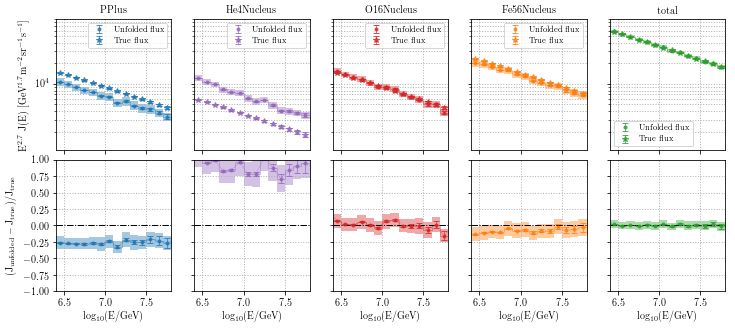

In [103]:
for model_name in ['Jeffreys']:
    
    # Get plotting axis
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(nrows=2, ncols=len(comp_list)+1,
                           hspace=0.075)
    axs_flux, axs_ratio = {}, {}
    for idx, composition in enumerate(comp_list + ['total']):
        if idx == 0:
            axs_flux[composition] = fig.add_subplot(gs[0, idx])
        else:
            axs_flux[composition] = fig.add_subplot(gs[0, idx], sharey=axs_flux[comp_list[0]])
        axs_ratio[composition] = fig.add_subplot(gs[1, idx], sharex=axs_flux[composition])
        

    print('{}: {} iterations'.format(model_name, df_unfolding_iter.shape[0]))

    counts, counts_sys_err, counts_stat_err = unfolded_counts_dist(
                                                    df_unfolding_iter,
                                                    num_groups=num_groups)
    for idx, composition in enumerate(comp_list + ['total']):
        
        ax_flux = axs_flux[composition]
        ax_ratio = axs_ratio[composition]
        
        # Flux plot
        flux, flux_err_sys = comp.get_flux(counts[composition], counts_sys_err[composition],
                                                    energybins=energybins.energy_bins,
                                                    eff_area=thrown_area,
                                                    livetime=livetime, livetime_err=livetime_err, 
                                                    solid_angle=solid_angle,
                                                    scalingindex=2.7)
        flux, flux_err_stat = comp.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle,
                                                     scalingindex=2.7)
        
        comp.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
                            ax=ax_flux, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])

        ax_flux.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
                         color=color_dict[composition], ls='None', marker='.', 
                         label='Unfolded flux', alpha=0.8)

        # True flux
        true_counts = counts_true[composition].values
        true_counts_err = np.sqrt(true_counts)

        true_flux, true_flux_err = comp.get_flux(true_counts, true_counts_err,
                                                energybins=energybins.energy_bins,
                                                eff_area=eff_area[composition],
                                                eff_area_err=eff_area_err[composition],
                                                livetime=livetime, livetime_err=livetime_err, 
                                                solid_angle=solid_angle,
                                                scalingindex=2.7)
        
        
        ax_flux.errorbar(energybins.log_energy_midpoints, true_flux, yerr=true_flux_err,  
                         color=color_dict[composition], ls='None', marker='*', 
                         label='True flux', alpha=0.8)

        ax_flux.set_yscale("log", nonposy='clip')
        ax_flux.set_xlim(6.4, 7.8)
        ax_flux.grid(linestyle='dotted', which="both", lw=1)
        ax_flux.legend(fontsize=8)
        ax_flux.set_title(composition, fontsize=10)
        if idx == 0:
            ax_flux.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$',
                               fontsize=10)
        else:
            plt.setp(ax_flux.get_yticklabels(), visible=False)
        plt.setp(ax_flux.get_xticklabels(), visible=False)
        ax_flux.tick_params(axis='both', which='major', labelsize=10)
        
        
        # Ratio plot
        diff = flux - true_flux
        # Error bar calculation
        diff_err_sys = flux_err_sys
        diff_err_stat = np.sqrt(flux_err_stat**2 + true_flux_err**2)
        
        frac_diff, frac_diff_sys = comp.ratio_error(diff, diff_err_sys, true_flux, np.zeros_like(true_flux))
        frac_diff, frac_diff_stat = comp.ratio_error(diff, diff_err_stat, true_flux, true_flux_err)
        
        comp.plot_steps(energybins.log_energy_bins, frac_diff, yerr=frac_diff_sys,
                            ax=ax_ratio, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])
        ax_ratio.errorbar(energybins.log_energy_midpoints, frac_diff, yerr=frac_diff_stat,  
                          color=color_dict[composition], ls=':', marker='.', 
                          label=composition, alpha=0.8)
        ax_ratio.axhline(0, ls='-.', lw=1, marker='None', color='k')

        ax_ratio.grid(linestyle='dotted', which="both", lw=1)
        extraticks = np.arange(-1, 1.5, 0.25)
        ax_ratio.set_yticks(extraticks)
        ax_ratio.set_ylim(-1, 1)
        if idx == 0:
            ax_ratio.set_ylabel('$\mathrm{(J_{unfolded} - J_{true}) / J_{true}}$',
                                fontsize=10)
        else:
            plt.setp(ax_ratio.get_yticklabels(), visible=False)
        ax_ratio.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$', fontsize=10)
        ax_ratio.tick_params(axis='both', which='major', labelsize=10)
        
    
    plt.tight_layout()
    flux_outfile = os.path.join(figures_dir, 
                                'flux_diff_grid_{}-groups_{}-prior.png'.format(num_groups, model_name))
    comp.check_output_dir(flux_outfile)
    plt.savefig(flux_outfile)
    plt.show()

Jeffreys: 3 iterations


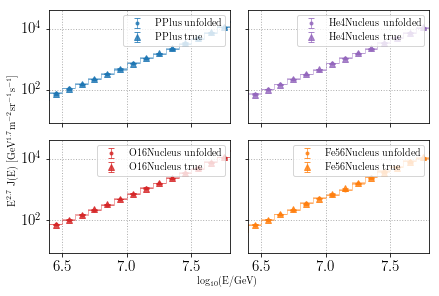

In [98]:
for model_name in ['Jeffreys']:
    fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
    print('{}: {} iterations'.format(model_name, df_unfolding_iter.shape[0]))

    counts, counts_sys_err, counts_stat_err = unfolded_counts_dist(
                                                df_unfolding_iter,
                                                num_groups=num_groups)


    flux_total, flux_total_err_sys = comp.analysis.get_flux(counts['total'], counts_sys_err['total'],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
    flux_total, flux_total_err_stat = comp.analysis.get_flux(counts['total'], counts_stat_err['total'],
                                                 energybins=energybins.energy_bins,
                                                 eff_area=thrown_area,
                                                 livetime=livetime, livetime_err=livetime_err, 
                                                 solid_angle=solid_angle)


    for composition, ax in zip(comp_list, axarr.flatten()):

        flux, flux_err_sys = comp.analysis.get_flux(
                                        counts[composition], counts_sys_err[composition],
                                        energybins=energybins.energy_bins,
                                        eff_area=thrown_area,
                                        livetime=livetime,
                                        livetime_err=livetime_err, 
                                        solid_angle=solid_angle)
        flux, flux_err_stat = comp.analysis.get_flux(
                                        counts[composition], counts_stat_err[composition],
                                        energybins=energybins.energy_bins,
                                        eff_area=thrown_area,
                                        livetime=livetime,
                                        livetime_err=livetime_err, 
                                        solid_angle=solid_angle)

        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])

        ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
                    color=color_dict[composition], ls='None', marker='.', 
                    label=composition + ' unfolded', alpha=0.8)

        # True flux
        true_counts = counts_true[composition].values
        true_counts_err = np.sqrt(true_counts)

        true_flux, true_flux_err = comp.analysis.get_flux(
                                                true_counts, true_counts_err,
                                                energybins=energybins.energy_bins,
                                                eff_area=eff_area[composition],
                                                eff_area_err=eff_area_err[composition],
                                                livetime=livetime, livetime_err=livetime_err, 
                                                solid_angle=solid_angle)

        ax.errorbar(energybins.log_energy_midpoints, true_flux, yerr=true_flux_err,  
                    color=color_dict[composition], ls='None', marker='^', 
                    label=composition + ' true', alpha=0.8)

        ax.set_yscale("log", nonposy='clip')
        ax.set_xlim(6.4, 7.8)
#         ax.set_ylim([1e0, 7e3])

        ax.grid(linestyle='dotted', which="both", lw=1)
        ax.legend(loc='upper right', ncol=1, fontsize=10)

    fig.text(0.5, -0.01, '$\mathrm{\log_{10}(E/GeV)}$', ha='center')
    fig.text(-0.01, 0.5, '$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$',
             va='center', rotation='vertical')

    flux_outfile = os.path.join(figures_dir, 
                                'flux_grid_{}-groups_{}-prior.png'.format(num_groups, model_name))
    comp.check_output_dir(flux_outfile)
    plt.savefig(flux_outfile)
    plt.show()

Jeffreys: 3 iterations


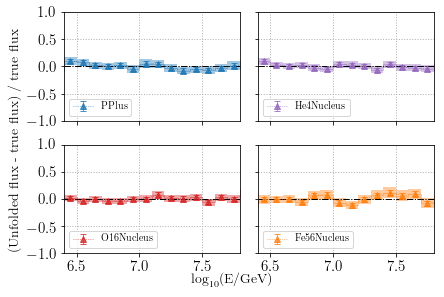

In [33]:
for model_name in ['Jeffreys']:
    fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
    print('{}: {} iterations'.format(model_name, df_unfolding_iter.shape[0]))

    counts, counts_sys_err, counts_stat_err = unfolded_counts_dist(
                                                df_unfolding_iter,
                                                num_groups=num_groups)
    for composition, ax in zip(comp_list, axarr.flatten()):

        flux, flux_err_sys = comp.analysis.get_flux(counts[composition], counts_sys_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle,
                                                     scalingindex=1)
        flux, flux_err_stat = comp.analysis.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle,
                                                     scalingindex=1)

        # True flux
        true_counts = counts_true[composition].values
        true_counts_err = np.sqrt(true_counts)

        true_flux, true_flux_err = comp.analysis.get_flux(true_counts, true_counts_err,
                                                energybins=energybins.energy_bins,
                                                eff_area=eff_area[composition],
                                                eff_area_err=eff_area_err[composition],
                                                livetime=livetime, livetime_err=livetime_err, 
                                                solid_angle=solid_angle,
                                                scalingindex=1)
        
        diff = flux - true_flux
        # Error bar calculation
        diff_err_sys = flux_err_sys
        diff_err_stat = np.sqrt(flux_err_stat**2 + true_flux_err**2)
        
        frac_diff, frac_diff_sys = comp.ratio_error(diff, diff_err_sys, true_flux, np.zeros_like(true_flux))
        frac_diff, frac_diff_stat = comp.ratio_error(diff, diff_err_stat, true_flux, true_flux_err)
        
        plotting.plot_steps(energybins.log_energy_bins, frac_diff, yerr=frac_diff_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])
        ax.errorbar(energybins.log_energy_midpoints, frac_diff, yerr=frac_diff_stat,  
                    color=color_dict[composition], ls=':', marker='^', 
                    label=composition, alpha=0.8)
        ax.axhline(0, ls='-.', lw=1, marker='None', color='k')

        ax.grid(linestyle='dotted', which="both", lw=1)
        ax.legend(loc='lower left', ncol=1, fontsize=10)
        extraticks = np.arange(-1, 1.5, 0.5)
        ax.set_yticks(extraticks)
    
    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(-1, 1)
    fig.text(0.5, -0.01, '$\mathrm{\log_{10}(E/GeV)}$', ha='center',
             fontsize=14)
    fig.text(-0.02, 0.5, '(Unfolded flux - true flux) / true flux',
             va='center', rotation='vertical', fontsize=14)
    plt.tight_layout()

#     flux_outfile = os.path.join(figures_dir, 
#                                 'flux_diff_grid_{}-groups_{}-prior.png'.format(num_groups, model_name))
#     comp.check_output_dir(flux_outfile)
#     plt.savefig(flux_outfile)
    plt.show()

In [58]:
frac_flux_diff, frac_flux_diff_stat, frac_flux_diff_sys = defaultdict(list), defaultdict(list), defaultdict(list)
ts_stopping_list = np.linspace(0.01, 0.001, 10)
for ts_stopping in pyprind.prog_bar(ts_stopping_list):
    df_unfolding_iter = unfold(config_name=os.path.join(config, 'config.cfg'),
                               priors='Jeffreys',
                               input_file=root_file,
                               ts_stopping=ts_stopping)
    
    counts, counts_sys_err, counts_stat_err = unfolded_counts_dist(
                                                df_unfolding_iter,
                                                num_groups=num_groups)

    for composition in comp_list:

        flux, flux_err_sys = comp.analysis.get_flux(counts[composition], counts_sys_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle,
                                                     scalingindex=1)
        flux, flux_err_stat = comp.analysis.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=thrown_area,
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle,
                                                     scalingindex=1)

        # True flux
        true_counts = counts_true[composition].values
        true_counts_err = np.sqrt(true_counts)

        true_flux, true_flux_err = comp.analysis.get_flux(true_counts, true_counts_err,
                                                energybins=energybins.energy_bins,
                                                eff_area=eff_area[composition],
                                                eff_area_err=eff_area_err[composition],
                                                livetime=livetime, livetime_err=livetime_err, 
                                                solid_angle=solid_angle,
                                                scalingindex=1)

        diff = flux - true_flux
        # Error bar calculation
        diff_err_sys = flux_err_sys
        diff_err_stat = np.sqrt(flux_err_stat**2 + true_flux_err**2)

        frac_diff, frac_diff_sys = comp.ratio_error(diff, diff_err_sys, true_flux, np.zeros_like(true_flux))
        frac_diff, frac_diff_stat = comp.ratio_error(diff, diff_err_stat, true_flux, true_flux_err)
        
        frac_flux_diff[composition].append(frac_diff)
        frac_flux_diff_stat[composition].append(frac_diff_stat)
        frac_flux_diff_sys[composition].append(frac_diff_sys)

0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:01:12


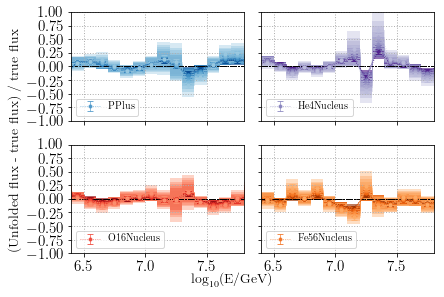

In [59]:
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)

color_dict_model = {}
color_dict_model['PPlus'] = sns.color_palette('Blues', len(ts_stopping_list)+5).as_hex()[::-1]
color_dict_model['O16Nucleus'] = sns.color_palette('Reds', len(ts_stopping_list)+5).as_hex()[::-1]
color_dict_model['He4Nucleus'] = sns.color_palette('Purples', len(ts_stopping_list)+5).as_hex()[::-1]
color_dict_model['Fe56Nucleus'] = sns.color_palette('Oranges', len(ts_stopping_list)+5).as_hex()[::-1]

for composition, ax in zip(comp_list, axarr.flatten()):
    for idx, (frac_diff, frac_diff_stat, frac_diff_sys) in enumerate(zip(frac_flux_diff[composition],
                                                                         frac_flux_diff_stat[composition],
                                                                         frac_flux_diff_sys[composition])):

        ax.errorbar(energybins.log_energy_midpoints, frac_diff,
                    yerr=frac_diff_stat, color=color_dict_model[composition][idx],
                    ls=':', marker='.', 
                    label=composition if idx == len(ts_stopping_list)//2 else '',
                    alpha=0.75)
        plotting.plot_steps(energybins.log_energy_bins, frac_diff, yerr=frac_diff_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict_model[composition][idx])
        ax.axhline(0, ls='-.', lw=1, marker='None', color='k')

        ax.grid(linestyle='dotted', which="both", lw=1)
        ax.legend(loc='lower left', ncol=1, fontsize=10)
        
        extraticks = np.arange(-1, 1.25, 0.25)
        ax.set_yticks(extraticks)

    ax.set_xlim(6.4, 7.8)
    ax.set_ylim(-1, 1)
fig.text(0.5, -0.01, '$\mathrm{\log_{10}(E/GeV)}$',
         ha='center', fontsize=14)
fig.text(-0.02, 0.5, '(Unfolded flux - true flux) / true flux',
         va='center', rotation='vertical', fontsize=14)
plt.tight_layout()

flux_compare_outfile = os.path.join(
                        figures_dir, 
                        'flux_compare_grid_{}-groups_Jeffreys-prior.png'.format(num_groups))
comp.check_output_dir(flux_compare_outfile)
plt.savefig(flux_compare_outfile)
plt.show()